# Ejemplo del Wavelet denoising

Ejemplo usando chirp function

N =  1024


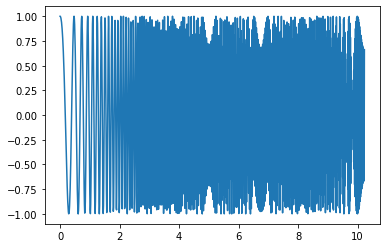

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import stats
from scipy import signal

# composicion de nueva señal chirp
f1_ = 1 # Frecuencia inicial del chirp
f2_ = 50 # Frecuencia final del chirp

Fs = 100 # Frecuencia de muestreo

t = np.arange(0,10.24,1/Fs) # vector de tiempos
N_ = len(t)
print("N = ", N_)

x_ = signal.chirp(t, f1_, t[-1], f2_) # Señal sin ventana
x_w = x_*signal.get_window('hamming',len(x_)) # Señal con ventana

# grafico del chirp
plt.plot(t, x_)

In [6]:
def pywt_swt(data, wname = 'db8', level=5, thres='hard', thresh_coe=10, process=False ):
    thresh_coe *= 0.67
    w = pywt.Wavelet(wname)
    coeffs = pywt.swt(data, w, level=level)
    coeffs_rec = []
    if process:
        plt.figure(figsize=(10,6))
        for i in range(len(coeffs)):
            plt.subplot(level,2,2*i+1)
            plt.plot(coeffs[i][1][0:2000])
            plt.subplot(level,2,2*i+2)
            plt.plot(coeffs[i][0][0:2000])
        
    for i in range(len(coeffs)):
        a_i = coeffs[i][0]
        mad = stats.median_abs_deviation(coeffs[i][1])
        d_i = pywt.threshold(coeffs[i][1], thresh_coe * mad, thres)
        coeffs_rec.append((a_i, d_i))

    data_rec = pywt.iswt(coeffs_rec, w)
    return data_rec


def hard_threshold(data, value, substitute=0):
    # In-place hard threshold using factor * MAD
    cond = np.less(np.absolute(data), value)
    data[cond] = substitute


cpu denoise: 0.584933s


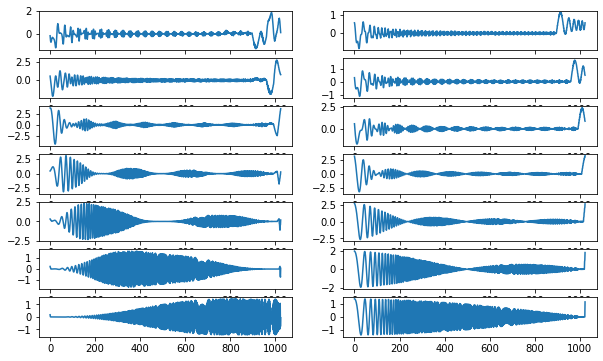

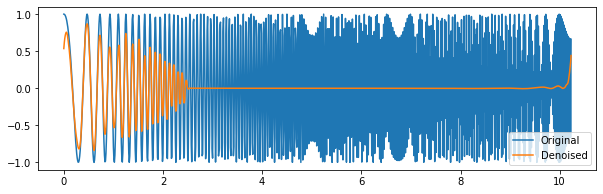

In [7]:
from time import time
import matplotlib.pyplot as plt

# Medida de rendimiento
cpu_start = time()
cpu_denoised_data = pywt_swt(x_, wname="rbio1.3", level=7, thres='hard', process=True)
print("cpu denoise: {:f}s".format(time()-cpu_start))
plt.figure(figsize=(10,3))
plt.plot(t[0:30000],x_[0:30000])
plt.plot(t[0:30000],cpu_denoised_data[0:30000])
plt.legend(['Original', 'Denoised'])




### Uso del codigo contruido por mi

In [8]:
# Extraccion de las funciones Wavelet

wname = 'rbio1.3'
wrb = pywt.Wavelet(wname)
(phi1, psi1, phi2, psi2, x) = wrb.wavefun()
# Obtencion de los filtros a partir de la libreria
(LoD, HiD, LoR, HiR) = wrb.filter_bank

In [9]:
level = 7; # niveles de descomposicion

r = x_.copy()
s = len(r) # longitud de la señal
pow = 2**level

# uso de los filtros para descomposicion
lo = LoD
hi = HiD

swd = np.zeros([level, s]) # matriz para almacenar detalles
swa = np.zeros([level, s]) # matriz para almacenar aproximaciones

x_da = r.copy()

for k in range(level):
    # extension de la señal 
    lf = len(lo)  # Longitud del filtro
    sx = len(r)  # longitud de la señal

    sf = lf/2
    I = np.concatenate([np.arange(sx-sf+1,sx),np.arange(1,sx), np.arange(1,sf)])
    I = I.astype(int)
    # vector de localizacion para extension de los datos, esto se hace para tener datos al inicio para la acomodacion o memoria de los filtros, y poder descartarlos
    x_in = x_da[I].copy() # Extension de los datos de entrada

    # descomposicion
    covd = np.convolve(x_in, hi, mode='full') # regresa la convolucion entre los datos y el filtro
    yout_ = covd[lf+1:lf+1+s] # Toma los datos de interes
    swd[k,:] = yout_
    cova = np.convolve(x_in, lo, mode='full') # regresa la convolucion entre los datos y el filtro
    yout_ = cova[lf+1:lf+1+s] # Toma los datos de interes
    swa[k,:] = yout_

    # upsample de los filtros
    l2fil = 2*len(lo) # nueva longitud del filtro
    yfil = np.zeros([l2fil])
    yfil[0::2] = lo
    lo = yfil.copy()

    l2fil = 2*len(hi) # nueva longitud del filtro
    yfil = np.zeros([l2fil])
    yfil[0::2] = hi
    hi = yfil.copy()

    x_da = swa[k,:] # el nuevo dato de entrada sera la ultima aproximacion

wdec = np.vstack([swd, swa[level-1,:]])



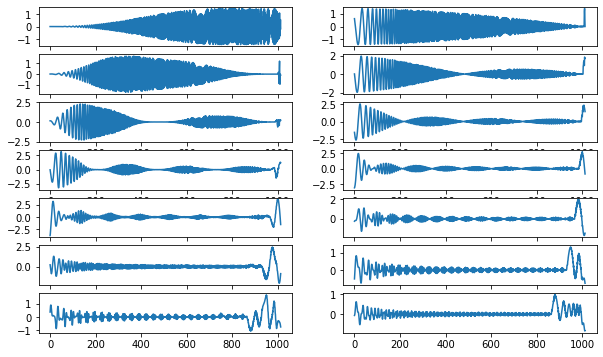

In [10]:
# Grafica de la descomposicion

plt.figure(figsize=(10,6))
for i in range(level):
    plt.subplot(level,2,2*i+1)
    plt.plot(swd[i][10:2010])
    plt.subplot(level,2,2*i+2)
    plt.plot(swa[i][10:2010])

In [11]:
# Hard Thresholding only in details

swd_den = swd.copy()
swa_den = swa.copy()

def thresh(x, th):
    for i in range(len(x)):
        if (x[i] < th):
            x[i] = 0
    return x

for i in range(level):
    mad = stats.median_abs_deviation(swd_den[i,:])
    swd_den[i,:] = thresh(swd_den[i,:], 10*mad)
    

wden = np.vstack([swd_den, swa_den[level-1,:]])

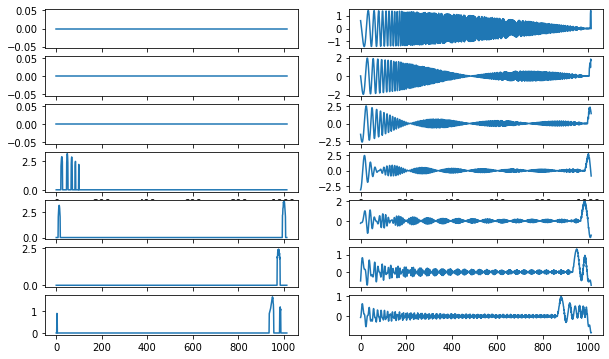

In [12]:
# Grafica de la descomposicion

plt.figure(figsize=(10,6))
for i in range(level):
    plt.subplot(level,2,2*i+1)
    plt.plot(swd_den[i][10:2010])
    plt.subplot(level,2,2*i+2)
    plt.plot(swa_den[i][10:2010])

In [13]:
# uso de los filtros para reconstruccion
lo = LoR
hi = HiR

de = swd_den.copy()            # matriz para almacenar detalles
ap = swa_den[level-1,:].copy() # matriz para almacenar aproximaciones

lxi = de.shape[1]

for k in range(level,0,-1):
    step = 2**(k-1)
    last = step
    for first in range(last):
        ind = np.arange(first, lxi-1, step)
        lon = len(ind)
        subind = ind[0:lon:2] # indices impares

        # proceso para el filtro pasa bajas
        lfi =len(lo) # tamaño del filtro
        lap = 2*len(ap[subind]) # nueva longitud de los datos
        y1 = np.zeros([lap]) # vector para los datos
        y1[1:lap:2] = ap[subind] # remuestreo de la señal
        sy1 = len(y1)

        sfi = lfi/2
        Ii = np.concatenate([np.arange(sy1-sfi+1,sy1),np.arange(1,sy1), np.arange(1,sfi)])
        Ii = Ii.astype(int) # vector de localizacion para extension de los datos, esto se hace para tener datos al inicio para la acomodacion o memoria de los filtros, y poder descartarlos

        y1 = y1[Ii] # extension de los datos de entrada
        yf1 = np.convolve(y1, lo, mode='full')
        yf1 = yf1[lfi:lfi+lon]

        # proceso para el filtro pasa altas
        lfi = len(hi) # tamaño del filtro
        lde = 2*len(de[k-1,subind])  # nueva longitud de los datos
        y2 = np.zeros([lde])  # vector para los datos
        y2[1:lde:2] = de[k-1,subind]  # remuestreo de la señal
        sy2 = len(y2) # longitud del vecto de entrada

        sfi = lfi/2
        Ii = np.concatenate([np.arange(sy2-sfi+1,sy2),np.arange(1,sy2), np.arange(1,sfi)])
        Ii = Ii.astype(int) # vector de localizacion para extension de los datos, esto se hace para tener datos al inicio para la acomodacion o memoria de los filtros, y poder descartarlos

        y2 = y2[Ii] # extension de los datos de entrada
        yf2 = np.convolve(y2, hi, mode='full')
        yf2 = yf2[lfi:lfi+lon]

        yout_1 = yf1 + yf2
        subind = ind[1:lon:2]  # indices pares

        # Transformada inversa del segmento
        # proceso para el filtro pasa bajas
        lfi =len(lo) # tamaño del filtro
        lap = 2*len(ap[subind]) # nueva longitud de los datos
        y1 = np.zeros([lap]) # vector para los datos
        y1[1:lap:2] = ap[subind] # remuestreo de la señal
        sy1 = len(y1)

        sfi = lfi/2
        Ii = np.concatenate([np.arange(sy1-sfi+1,sy1),np.arange(1,sy1), np.arange(1,sfi)])
        Ii = Ii.astype(int) # vector de localizacion para extension de los datos, esto se hace para tener datos al inicio para la acomodacion o memoria de los filtros, y poder descartarlos

        y1 = y1[Ii] # extension de los datos de entrada
        yf1 = np.convolve(y1, lo, mode='full')
        yf1 = yf1[lfi:lfi+lon]

        # proceso para el filtro pasa altas
        lfi = len(hi) # tamaño del filtro
        lde = 2*len(de[k-1,subind])  # nueva longitud de los datos
        y2 = np.zeros([lde])  # vector para los datos
        y2[1:lde:2] = de[k-1,subind]  # remuestreo de la señal
        sy2 = len(y2) # longitud del vecto de entrada

        sfi = lfi/2
        Ii = np.concatenate([np.arange(sy2-sfi+1,sy2),np.arange(1,sy2), np.arange(1,sfi)])
        Ii = Ii.astype(int) # vector de localizacion para extension de los datos, esto se hace para tener datos al inicio para la acomodacion o memoria de los filtros, y poder descartarlos

        y2 = y2[Ii] # extension de los datos de entrada
        yf2 = np.convolve(y2, hi, mode='full')
        yf2 = yf2[lfi:lfi+lon]

        yout_2 = yf1 + yf2
        yout_2 = np.flip(yout_2)

        ap[ind] = 0.5*(yout_1 + yout_2)

xrec = ap

    

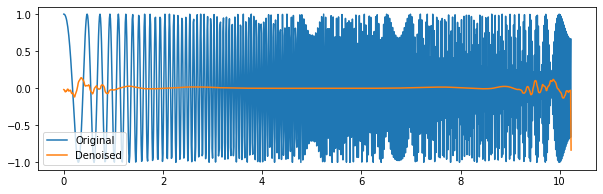

In [14]:
plt.figure(figsize=(10,3))
plt.plot(t[0:30000],r[0:30000])
plt.plot(t[0:30000],xrec[0:30000])
plt.legend(['Original', 'Denoised'])